# Evaluating an Image

After training our model, we will want to do a number of things<br>
1. see how are model did
2. test our model on an image where we have labeled data
3. evaluate an image where we don't have labeled data

This script goes through the functions that let us perform these tasks

In [1]:
from evaluate import *
parent_dir  = "/home/abid/Dropbox/Development/programs/stem-learning/"                            

Using TensorFlow backend.


# 1. Model Diagnostics

How do we know that we've finished training our model? We have to look at the diagnostics that were output from the training. We load in the diagnostics file with **get_diagnostics** which takes in the path to the diagnostics file as input

In [3]:
results_dir = parent_dir + "results_64/CoMTPP/"
diagnostics_data = get_diagnostic_data(results_dir)

values: ['step', 'loss', 'acc', 'val_loss', 'val_acc', 'TP', 'FP', 'FN', 'TN', 'recall', 'precision', 'F1', 'bal_acc']
number of data points: 148


To evaluate an image, we need the following parameters:

**model_fn**         is the path to the model file that we load
<br>
**model_weights_fn** is the path to the model weights file
<br>
**input_file**       is the file we're interested in evaluating
<br>
**l_shape**          This is the size of the images that are fed into the model (see preprocessing section)
<br>
**avg**              is 1 if we want to average over rotatations and flips, 0 if we just want to evaluate the image as is
<br>
**plot**             true if we want to see the plots here
<br>
**save_data**        true if we want to save the plots to a file
<br>
**save_dir**         directory for where we want to save the data
<br>
**prefix**           if we want to save the images, we can apply a prefix to the image names.

In [10]:

data_dir = parent_dir + "data/CoMTPP/0/"


model_fn = results_dir + "model.json"                                              
model_weights_fn = results_dir + "weights.h5"
input_file =  data_dir + "input.tif"
l_shape = (64, 64)
stride  = (48, 48)
avg = 1
plot=True
save_data=True
save_dir = "./"                                                         
prefix = "M-CuPcCl_CuPcCl_"

processing data
loading model
strides: (48, 48)
predicting data
stitching data
saving data


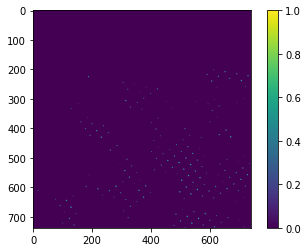

In [11]:
%matplotlib inline
prediction = evaluate(model_fn, model_weights_fn, input_file, l_shape, stride,
                      avg=avg, plot=plot, save_data=save_data, save_dir=save_dir, prefix=prefix)

To test against the true labeled data, we run **test** which takes in the following:

**prediction** the output from **evaluate**
<br>
**label_file_list** is a list of label images associated with the input file (empty list if none)
<br>
**tol** the threshold for the labeled images that pixels with values <= tol to 0 and values > tol to 1
<br>
**plot** true if we want to see the plots here
<br>
**save_data** true if we want to save the plots to a file
<br>
**save_dir** directory for where we want to save the data
<br>
**prefix** if we want to save the images, we can apply a prefix to the image names.

In [12]:
label_file_list = [data_dir + "label_CoMTPP.tif"]
tol=.5
plot=True
save_data=True
save_dir = "./"                                                         
prefix = "M-CoMTPP_CoMTPP_64_"

<IPython.core.display.Javascript object>


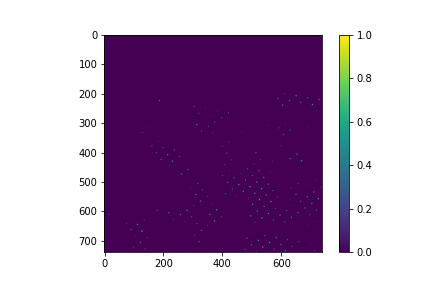

<IPython.core.display.Javascript object>


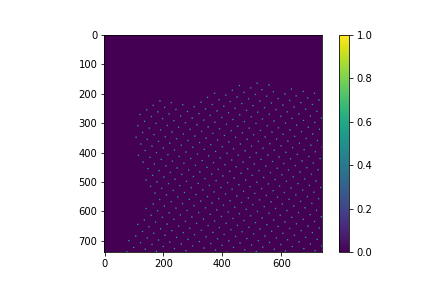

<IPython.core.display.Javascript object>


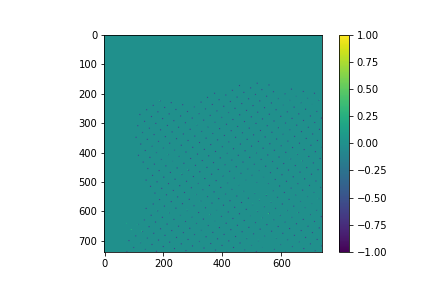

<IPython.core.display.Javascript object>


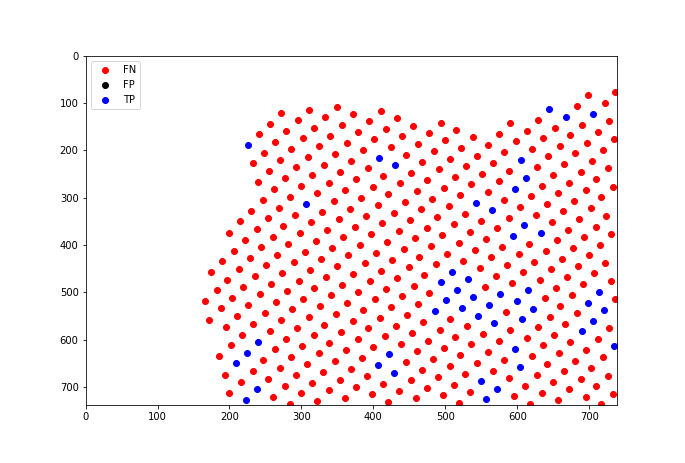

saving data


In [14]:
%matplotlib notebook
diff = test(prediction, label_file_list, r=3, tol=tol, plot=True, save_data=True, save_dir="./", prefix="")